In [1]:
from pathlib import Path

from rosbags.dataframe import get_dataframe
from rosbags.highlevel import AnyReader

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
dataframe = None
with AnyReader([Path('my_bag')]) as reader:
    dataframe = get_dataframe(reader, '/cmd_vel', ['linear', 'angular'])

In [31]:
dataframe = dataframe.reset_index()

In [33]:
dataframe.head()

,index,linear,angular
0,2023-07-28 22:49:27.327648020,"geometry_msgs__msg__Vector3(x=-0.0, y=0.0, z=0...","geometry_msgs__msg__Vector3(x=0.0, y=0.0, z=-0..."
1,2023-07-28 22:49:27.327740108,"geometry_msgs__msg__Vector3(x=-0.0, y=0.0, z=0...","geometry_msgs__msg__Vector3(x=0.0, y=0.0, z=-0..."
2,2023-07-28 22:49:27.327759903,"geometry_msgs__msg__Vector3(x=-0.0, y=0.0, z=0...","geometry_msgs__msg__Vector3(x=0.0, y=0.0, z=-0..."
3,2023-07-28 22:49:27.327772303,"geometry_msgs__msg__Vector3(x=-0.0, y=0.0, z=0...","geometry_msgs__msg__Vector3(x=0.0, y=0.0, z=-0..."
4,2023-07-28 22:49:27.327785326,"geometry_msgs__msg__Vector3(x=-0.0, y=0.0, z=0...","geometry_msgs__msg__Vector3(x=0.0, y=0.0, z=-0..."


In [44]:
index = 50

In [45]:

dataframe.loc[index, 'linear'].x

1.0

In [46]:
dataframe.loc[index, 'angular'].z

-0.0

In [9]:
dataframe2 = None
with AnyReader([Path('my_bag')]) as reader:
    dataframe2 = get_dataframe(reader, '/camera/image_raw', ['data'])

In [47]:
dataframe2.head()

,index,data
0,2023-07-28 22:49:27.333034126,"[175, 175, 175, 175, 175, 175, 175, 175, 175, ..."
1,2023-07-28 22:49:27.353144365,"[175, 175, 175, 175, 175, 175, 175, 175, 175, ..."
2,2023-07-28 22:49:27.363090335,"[175, 175, 175, 175, 175, 175, 175, 175, 175, ..."
3,2023-07-28 22:49:27.364273769,"[175, 175, 175, 175, 175, 175, 175, 175, 175, ..."
4,2023-07-28 22:49:27.406454495,"[175, 175, 175, 175, 175, 175, 175, 175, 175, ..."


In [19]:
dataframe2 = dataframe2.reset_index()

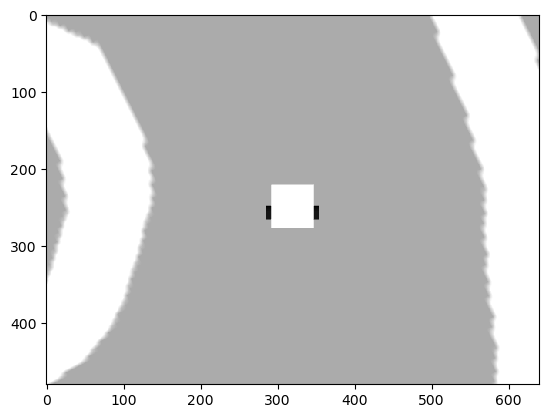

In [32]:
image_data = dataframe2.loc[0, 'data']
image_data
image_shape = (480, 640, 3)
dtype = np.uint8  # common for grayscale images in the range 0-255

image = np.frombuffer(image_data, dtype=dtype)
image = np.reshape(image, image_shape)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Now we can display the image
plt.imshow(gray_image, cmap='gray')
plt.show()

In [49]:
dataframe.shape

(89, 3)

In [50]:
dataframe2.shape

(85, 2)

In [51]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split


def load_data(df):
    images = []
    velocities = []

    for i in range(len(df)):
        # Get velocity data
        linear_velocity = df.loc[i, 'linear'].x
        angular_velocity = df.loc[i, 'angular'].z
        velocities.append([linear_velocity, angular_velocity])

        # Get image data
        image_data = df.loc[i, 'data']
        image_shape = (480, 640, 3)
        dtype = np.uint8  

        image = np.frombuffer(image_data, dtype=dtype)
        image = np.reshape(image, image_shape)
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        images.append(gray_image)

    # Normalize image pixel values to [0, 1]
    images = np.array(images, dtype="float") / 255.0
    velocities = np.array(velocities, dtype="float")

    return images, velocities

df = dataframe.merge(dataframe2, left_index=True, right_index=True, how='inner')


images, velocities = load_data(df)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, velocities, test_size=0.2, random_state=42)


In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_model(input_shape):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))  # Two output neurons for two velocities

    model.compile(optimizer='adam', loss='mse')  # Use mean squared error as loss function for regression problem

    return model

# Reshape the train and test data to include the channel dimension
X_train = X_train.reshape(X_train.shape[0], 480, 640, 1)
X_test = X_test.reshape(X_test.shape[0], 480, 640, 1)

model = create_model((480, 640, 1))


2023-07-28 23:59:46.629396: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-28 23:59:46.631311: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 23:59:46.648824: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-28 23:59:46.649251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-28 23:59:47.897945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [53]:
from tensorflow.config.experimental import list_physical_devices

KeyboardInterrupt: 

In [ ]:
print("Num GPUs Available: ", len(list_physical_devices('GPU')))

KeyboardInterrupt: 

In [53]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10)


KeyboardInterrupt: 

In [ ]:
loss = model.evaluate(X_test, y_test)
print("Test loss: ", loss)
